# Decoding stimulus identity from neural responses

We implement here a nearest-neighbor decoder of neural activity.

In [1]:
# general modules
import pynwb, os, sys
import numpy as np
import matplotlib.pylab as plt

# custom modules
sys.path.append('..')
from physion.dataviz.show_data import MultimodalData, EpisodeResponse
from datavyz import graph_env_manuscript as ge

In [2]:
filename = '/home/yann.zerlaut/DATA/curated/2022_03_07-15-31-56.nwb'
episodes = EpisodeResponse(filename, quantities=['dFoF', 'rawFluo', 'pupil'], verbose=True)
print(episodes.varied_parameters)
print(episodes.quantities)

NWB-file reading time: 176.2ms
  Number of episodes over the whole recording: 210/240 (with protocol condition)
  building episodes with 3 modalities [...]

calculating dF/F with method "maximin" [...]

  ** 24 ROIs were discarded with the positive F0 criterion (5.6%) ** 

-> dFoF calculus done !  (calculation took 0.9s)
  -> [ok] episodes ready !
{'Image-ID': array([0., 1., 2., 3., 4., 5.]), 'VSE-seed': array([3., 4.]), 'repeat': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17], dtype=int32)}
['dFoF']


FileNotFoundError: [Errno 2] No such file or directory: '/home/yann.zerlaut/miniconda3/envs/physion/lib/python3.7/site-packages/physion/visual_stim/NI_bank'

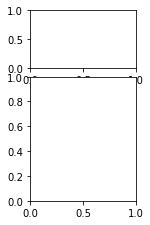

In [4]:
episodes = episode
episodes.plot_evoked_pattern(episodes.find_episode_cond(['Image-ID', 'VSE-seed'], [0,0]),
                             quantity='dFoF')


### find significantly responding neurons

In [3]:
        summary_data = episode.compute_summary_data(dict(interval_pre=[-1,0], interval_post=[1,2], test='wilcoxon', positive=True),
                                                    response_args={'quantity':'dFoF', 'roiIndex':2})


['dFoF']

In [3]:
episode.find_episode_cond(['Image-ID', 'VSE-seed'], [0,0])

array([False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False,  True,

In [4]:
def plot_evoked_pattern(self, 
                        pattern_cond, 
                        quantity='rawFluo',
                        rois=np.arange(5)):
    
    resp = np.array(getattr(self, quantity))
    print(np.mean(resp), np.min(resp))
    resp -= resp.min(axis=(0,2)).reshape(1,resp.shape[1],1)
    print(np.mean(resp))
    fig, [axR, axT] = ge.figure(axes_extents=[[[1,3]],
                                      [[1,4]]], 
                                figsize=(1.3,.3))
    
    # raster
    axR.imshow(resp[pattern_cond,:,:].mean(axis=0),
               cmap=ge.binary,
               aspect='auto', interpolation='none',
               #vmin=0, vmax=1, 
               #origin='lower',
               extent = (self.t[0], self.t[-1],
                         0, resp.shape[1]))

    ge.set_plot(axR, [], xlim=[self.t[0], self.t[-1]])
    
    for r in rois:
        shift = 4*r
        ge.plot(episode.t, shift+resp[pattern_cond, r, :].mean(axis=0), 
                sy=resp[pattern_cond, r, :].std(axis=0),ax=axT, no_set=True)
        for iep in range(np.sum(pattern_cond)):
            axT.plot(episode.t, shift+resp[pattern_cond, r, :][iep,:], color=ge.tab10(iep), lw=.5)
    ge.set_plot(axT, [], xlim=[self.t[0], self.t[-1]])
    
    return fig
fig = plot_evoked_pattern(episode, 
                          episode.find_episode_cond(['Image-ID', 'VSE-seed'], [0,0]))


AttributeError: 'EpisodeResponse' object has no attribute 'rawFluo'

In [ ]:
class PatternResponses(Data):
    """
    # inherited from the general Data class
    """
    
    def __init__(self, data,
                 protocol_id=0,
                 quantity='CaImaging', 
                 subquantity='Fluorescence',
                 nmax_ROI = 10000, # to limit the number of ROIs
                 build_dFoF_args={method_for_F0='maximin', sliding_window=60},
                 verbose=False):
        
        super().__init__()
        
        if subquantity in ['dFoF', 'dF/F']:
            
        data.CaImaging_key, EPISODES = subquantity, []
        # looping over cells, we get the episode responses
        for roi in range(np.sum(data.iscell))[:nmax_ROI]:
            data.roiIndices = [roi] 
            EPISODES.append(build_episodes(data, protocol_id=protocol_id,
                                           quantity=quantity, verbose=False))
        # now looping over conditions to build the pattern responses
        KEYS = data.varied_parameters.keys()
        VALUES = [v.flatten() for v in np.meshgrid(*[data.varied_parameters[k] for k in KEYS])]
        STIM = {}
        setattr(self, 'resp', [])
        for key in KEYS:
            STIM[key] = []
        for i in range(len(VALUES[0])):
            # looping over unique stimuli
            cond = np.ones(len(EPISODES[0]['resp']), dtype=bool)
            for key, values in zip(KEYS, VALUES):
                cond = cond & (EPISODES[0][key]==values[i])
                STIM[key].append(values[i])
            # now building the set of repeated pattern for a unique stim
            for icond in np.arange(len(EPISODES[0]['resp']))[cond]:
                pattern = np.zeros((len(EPISODES), len(EPISODES[0]['resp'][0]))) # shape (ROI, time)
                for roi, episodes in enumerate(EPISODES):
                    pattern[roi,:] = episodes['resp'][icond]
                getattr(self, 'resp').append(pattern)
        setattr(self, 'stim', STIM)
        setattr(self, 't', EPISODES[0]['t']) # time array corresponding to the patterns

filename = os.path.join(os.path.expanduser('~'), 'DATA', 'Wild_Type', '2021_03_19-14-51-17.nwb')
data = Data(filename)
patterns = PatternResponses(data, protocol_id=2,
                            quantity='CaImaging', 
                            subquantity='dF/F',
                            nmax_ROI=10)

In [ ]:
def show_pattern(self, i, ax=None, tlim=None, Tsubsampling=10, 
                 annotations = dict(Tbar=1, Rbar=5), space=0.03, rm_annot=False):
    if ax is None:
        fig, ax = plt.subplots(1, figsize=(3,1.8))
    if tlim is None:
        tlim = [self.t[0], self.t[-1]]
    dT, dN = (tlim[1]-tlim[0]), self.resp[i].shape[0]
    ax.imshow(self.resp[i][:,::Tsubsampling], cmap=plt.cm.binary,
              aspect='auto', interpolation='none', vmin=0, vmax=10, origin='lower',
              extent = (*tlim, 0, dN))
    if (annotations is not None) and not rm_annot:
        ax.plot([tlim[0]-space*dT, tlim[0]-space*dT+annotations['Tbar']], np.ones(2)*dN*(1+space), 'k')
        ax.annotate('%ss' % annotations['Tbar'], (tlim[0]-space*dT, dN*(1+space)))
        ax.plot(tlim[0]*np.ones(2)-space*dT, -annotations['Rbar']*np.arange(2)+dN*(1+space), 'k')
        ax.annotate('%scells' % annotations['Rbar'], (tlim[0]-space*dT, dN*(1+space)), va='top', ha='right', rotation=90)
        
    ax.set_xlim([tlim[0]-2*space*dT, tlim[1]])
    ax.set_ylim([0, (1+2*space)*dN])
    ax.axis('off')
    return ax

fig, AX = plt.subplots(10, 5, figsize=(15,15))
plt.subplots_adjust(top=.95, left=.02, right=1., bottom=0.)
IDS = np.arange(1,6)
for ii, ID in enumerate(IDS):
    cond = (np.array(patterns.stim['Image-ID'])==ID) & (np.array(patterns.stim['VSE-seed'])==1.)
    axi = AX[0][ii].inset_axes([0.5, 0.99, 0.4, 0.3])
    
    data.visual_stim.show_frame(np.argwhere((data.nwbfile.stimulus['Image-ID'].data[:]==ID))[0][0],
                                    ax=axi, label=None)
    
    for ir, i in enumerate(np.arange(len(patterns.stim['repeat']))[cond]):
        show_pattern(patterns, i, tlim=[-1,8], rm_annot=(ir>0), ax=AX[ir][ID-1])
        if ID==1:
            AX[ir][ID-1].annotate('trial#%i' % (ir+1), (AX[ir][0].get_xlim()[0], 0), ha='right')

## Defining a distance metrics for CaImaging responses

In [5]:
def Distance(Pattern1, Pattern2):
    """
    should have the shape (ROI, time)
    """
    return np.sum((Pattern1-Pattern2)**2)

X1 = np.ones((3,10))
X2 = np.zeros((3,10))


Distance(X2,X1)

30.0